## Train a ResNet

Modification of the following:
https://github.com/mrdbourke/pytorch-deep-learning/blob/main/06_pytorch_transfer_learning.ipynb

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[0]) >= 2, "torch version should be 2.0+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
    
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !move pytorch-deep-learning/going_modular .
    from going_modular.going_modular import data_setup, engine
    
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

torch version: 2.5.1+cu118
torchvision version: 0.20.1+cu118


c:\Users\Menee\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

### Load dataset and preprocessing
As described in methods

In [2]:
# Instead we do our own data collection
import pandas
import itertools
from sklearn.model_selection import train_test_split

pandasdf = pandas.read_csv('labels.csv')
pandasdf = pandasdf.drop(columns=['Type', 'Merk'])
unique_soort = pandasdf['Soort'].unique()
unique_grondstof = pandasdf['Grondstof'].unique()
# Classes are tuples; lets see how many we have
combinations = list(itertools.product(unique_soort, unique_grondstof))
combination_counts = {}
actual_classes = []
for soort, grondstof in combinations:
    count = pandasdf[(pandasdf['Soort'] == soort) & (pandasdf['Grondstof'] == grondstof)].shape[0]
    # Only include classes if we have more than 249 samples
    if count > 249:
        combination_counts[(soort, grondstof)] = count
        actual_classes.append((soort, grondstof))

# We filter the dataframe to only include saturated classes
filtered_pandasdf = pandasdf[pandasdf.apply(lambda row: (row['Soort'], row['Grondstof']) in actual_classes, axis=1)]

# # Group by 'Soort' and 'Grondstof' and take the first 250 samples from each group
# filtered_pandasdf = filtered_pandasdf.groupby(['Soort', 'Grondstof']).head(250).reset_index(drop=True)

# Concatenate 'Soort' and 'Grondstof' into a single column 'Class'
filtered_pandasdf['Class'] = filtered_pandasdf['Soort'] + '_' + filtered_pandasdf['Grondstof']
filtered_pandasdf = filtered_pandasdf.drop(columns=['Soort', 'Grondstof'])

filtered_pandasdf.head()

C:\Users\Menee\AppData\Local\Temp\ipykernel_13460\2630328022.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pandasdf['Class'] = filtered_pandasdf['Soort'] + '_' + filtered_pandasdf['Grondstof']


,File,Class
0,Fotos/B/BagPaper/BagPaper-00001.jpg,Bag_Paper
1,Fotos/B/BagPaper/BagPaper-00002.jpg,Bag_Paper
2,Fotos/B/BagPaper/BagPaper-00003.jpg,Bag_Paper
3,Fotos/B/BagPaper/BagPaper-00004.jpg,Bag_Paper
4,Fotos/B/BagPaper/BagPaper-00005.jpg,Bag_Paper


In [3]:
from datasets import ClassLabel

# Define the ClassLabel feature - this will map the string labels to integers
class_labels = [f"{soort}_{grondstof}" for soort, grondstof in actual_classes]
all_labels = ClassLabel(names=class_labels)

# Update the datasets with the ClassLabel feature
filtered_pandasdf['ClassLabel'] = filtered_pandasdf['Class'].map(lambda x: all_labels.str2int(x))
filtered_pandasdf = filtered_pandasdf.drop(columns=['Class'])

# These are now all available labels
print(f"Original number of combin classes: {len(combinations)}")

print(all_labels) # you can do .names for the names
label_names = all_labels.names
print(len(label_names))
print(len(class_labels))

filtered_pandasdf.head()

Original number of combin classes: 1068
ClassLabel(names=['Bag_Paper', 'Bag_Plastic', 'Balloon_Plastic', 'Ball_Plastic', 'Battery_Metal', 'Bikelamp_Plastic', 'Bikepart_Plastic', 'Bottlecap_Plastic', 'Bottlecap_Metal', 'Bottle_Plastic', 'Bottle_Glass', 'Bottlering_Plastic', 'Box_Cardboard', 'Breadclip_Plastic', 'Butt_Celluloseacetate', 'Can_Metal', 'Carpart_Plastic', 'Cleaningcloth_Microfibre', 'Clothes_Fabric', 'Clothespin_Plastic', 'Cloth_Fabric', 'Confetti_Plastic', 'Cup_Plastic', 'Cup_Cardboard', 'Drinkcarton_Plastic', 'drinkcarton_Plastic', 'Drinkpouch_Plastic', 'Ducttape_Plastic', 'Edge_Plastic', 'Firework_Plastic', 'Firework_Cardboard', 'Floss_Plastic', 'Flower_Plastic', 'Flyer_Paper', 'Foil_Aluminum', 'Fork_Plastic', 'Gascharger_Metal', 'Glove_Fabric', 'Hairtie_Plastic', 'Jar_Plastic', 'Label_Plastic', 'Lid_Plastic', 'Lid_Cardboard', 'Lighter_Plastic', 'Mouthcap_Plastic', 'Napkin_Paper', 'Pack_Plastic', 'Pack_Cardboard', 'Packingpeanut_Styrofoam', 'Pencil_Plastic', 'Piece_Paper'

,File,ClassLabel
0,Fotos/B/BagPaper/BagPaper-00001.jpg,0
1,Fotos/B/BagPaper/BagPaper-00002.jpg,0
2,Fotos/B/BagPaper/BagPaper-00003.jpg,0
3,Fotos/B/BagPaper/BagPaper-00004.jpg,0
4,Fotos/B/BagPaper/BagPaper-00005.jpg,0


In [4]:
# We do a split - 80% train, 20% test (for each class - balance is maintained)
train_df = pandas.DataFrame()
test_df = pandas.DataFrame()

for clazz, group in filtered_pandasdf.groupby(['ClassLabel']):
    train, test = train_test_split(group, test_size=0.2, random_state=42)
    train_df = pandas.concat([train_df, train])
    test_df = pandas.concat([test_df, test])

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(train_df.head(203), train_df.shape)
print(test_df.head(), test_df.shape)


                                                  File  ClassLabel
0                  Fotos/B/BagPaper/BagPaper-00141.jpg           0
1    Fotos/B/BagPaperFastfoodKfc/BagPaperFastfoodKf...           0
2    Fotos/B/BagPaperFastfood/BagPaperFastfood-0011...           0
3                  Fotos/B/BagPaper/BagPaper-00200.jpg           0
4    Fotos/B/BagPaperFastfoodMcdonalds/BagPaperFast...           0
..                                                 ...         ...
198                Fotos/B/BagPaper/BagPaper-00228.jpg           0
199  Fotos/B/BagPaperFastfoodKfc/BagPaperFastfoodKf...           0
200  Fotos/B/BagPaperFastfoodMcdonalds/BagPaperFast...           0
201  Fotos/B/BagPaperFastfoodMcdonalds/BagPaperFast...           0
202  Fotos/B/BagPaperFastfoodFebo/BagPaperFastfoodF...           0

[203 rows x 2 columns] (86551, 2)
                                                File  ClassLabel
0                Fotos/B/BagPaper/BagPaper-00052.jpg           0
1  Fotos/B/BagPaperFastfood/Bag

In [5]:
# Get a set of pretrained model weights
weights = torchvision.models.ResNet50_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [6]:
from torch.utils.data import DataLoader, Dataset
from PIL import Image
# https://discuss.pytorch.org/t/dataset-from-pandas-without-folder-structure/146816/3
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['File']
        image = Image.open(img_path).convert("RGB")
        label = self.dataframe.iloc[idx]['ClassLabel']

        if self.transform:
            image = self.transform(image)
        
        return image, label



train_ds = CustomDataset(train_df, transform=auto_transforms)
test_ds = CustomDataset(test_df, transform=auto_transforms)


In [7]:


# Create DataLoader for training and testing sets
train_dataloader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=32, shuffle=True)

train_dataloader, test_dataloader, label_names


(<torch.utils.data.dataloader.DataLoader at 0x1a1dacb8810>,
 ['Bag_Paper',
  'Bag_Plastic',
  'Balloon_Plastic',
  'Ball_Plastic',
  'Battery_Metal',
  'Bikelamp_Plastic',
  'Bikepart_Plastic',
  'Bottlecap_Plastic',
  'Bottlecap_Metal',
  'Bottle_Plastic',
  'Bottle_Glass',
  'Bottlering_Plastic',
  'Box_Cardboard',
  'Breadclip_Plastic',
  'Butt_Celluloseacetate',
  'Can_Metal',
  'Carpart_Plastic',
  'Cleaningcloth_Microfibre',
  'Clothes_Fabric',
  'Clothespin_Plastic',
  'Cloth_Fabric',
  'Confetti_Plastic',
  'Cup_Plastic',
  'Cup_Cardboard',
  'Drinkcarton_Plastic',
  'drinkcarton_Plastic',
  'Drinkpouch_Plastic',
  'Ducttape_Plastic',
  'Edge_Plastic',
  'Firework_Plastic',
  'Firework_Cardboard',
  'Floss_Plastic',
  'Flower_Plastic',
  'Flyer_Paper',
  'Foil_Aluminum',
  'Fork_Plastic',
  'Gascharger_Metal',
  'Glove_Fabric',
  'Hairtie_Plastic',
  'Jar_Plastic',
  'Label_Plastic',
  'Lid_Plastic',
  'Lid_Cardboard',
  'Lighter_Plastic',
  'Mouthcap_Plastic',
  'Napkin_Paper'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


<class 'torch.Tensor'>


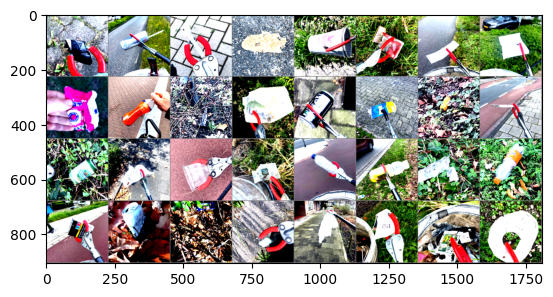

tensor([27, 78, 73,  0, 23, 46,  1, 61, 94,  9, 10, 46, 15, 15,  9, 77, 15, 88,
        22, 94,  9,  9, 80,  9, 46, 15, 24, 48, 71, 61, 69, 41])


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize (doesnt work with auto transforms)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)

ex_image, ex_label = next(dataiter)
print(type(ex_image))

# show images
imshow(torchvision.utils.make_grid(ex_image))
print(ex_label)

### Defining the model

In [9]:
model = torchvision.models.resnet50(weights=weights).to(device)

In [10]:
# Print a summary using torchinfo 
summary(model=model, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [11]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.parameters():
    param.requires_grad = False
    
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(label_names)

model.fc = nn.Linear(model.fc.in_features, output_shape).to(device)

# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 96]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [12]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train

In [13]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [30:16<2:01:06, 1816.69s/it]

Epoch: 1 | train_loss: 2.1001 | train_acc: 0.4647 | test_loss: 1.7642 | test_acc: 0.5342


 40%|████      | 2/5 [1:02:58<1:35:06, 1902.33s/it]

Epoch: 2 | train_loss: 1.6060 | train_acc: 0.5606 | test_loss: 1.6928 | test_acc: 0.5431


 60%|██████    | 3/5 [1:33:30<1:02:20, 1870.18s/it]

Epoch: 3 | train_loss: 1.4576 | train_acc: 0.5902 | test_loss: 1.6896 | test_acc: 0.5494


 80%|████████  | 4/5 [2:08:11<32:33, 1953.26s/it]  

Epoch: 4 | train_loss: 1.3664 | train_acc: 0.6116 | test_loss: 1.6455 | test_acc: 0.5609


100%|██████████| 5/5 [2:44:56<00:00, 1979.28s/it]

Epoch: 5 | train_loss: 1.3009 | train_acc: 0.6261 | test_loss: 1.6336 | test_acc: 0.5577
[INFO] Total training time: 9896.419 seconds


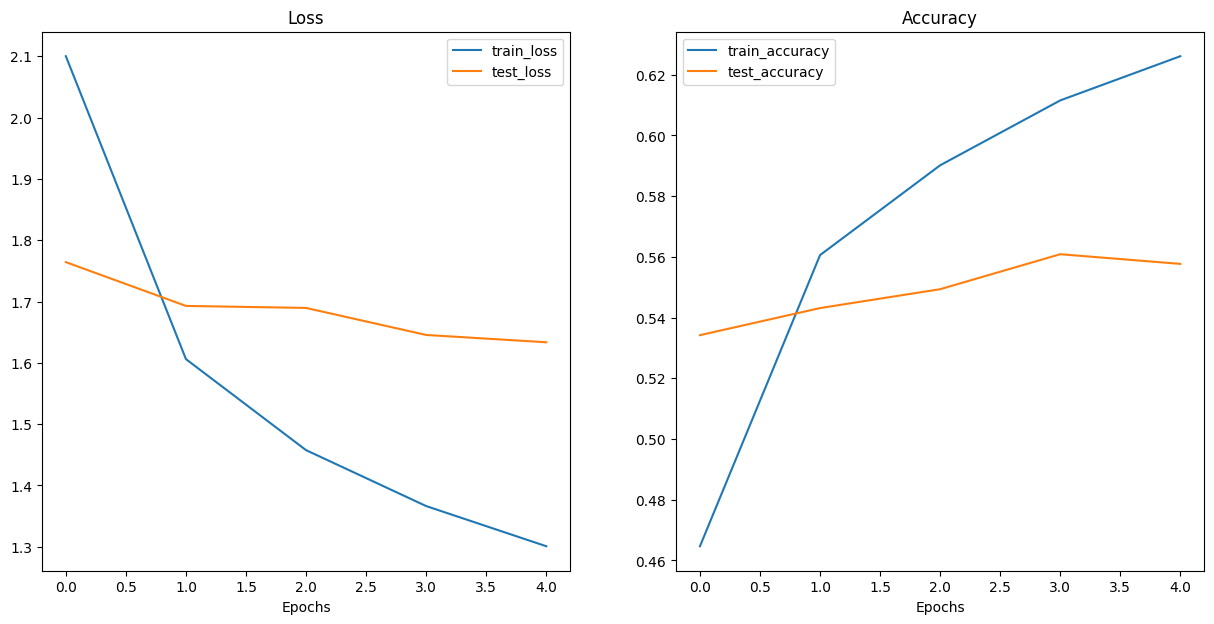

In [14]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [15]:
# Save the current model
model_save_path = "resnet-50-5epochs.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Function to load the model
def load_model(model_path, model, device):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    return model

# Example usage
model = load_model(model_save_path, model, device)


Model saved to resnet-50-5epochs.pth


C:\Users\Menee\AppData\Local\Temp\ipykernel_13460\1844433024.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

0